Step 1: Install & Imports
Text data requires a special library called nltk (Natural Language Toolkit).


In [8]:
import numpy as np
import pandas as pd
import re # Regular Expressions (for cleaning text)
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Download English stopwords (words like "the", "is", "and" that we remove)
nltk.download('stopwords')

print("✅ Libraries Imported & NLTK Data Downloaded!")

✅ Libraries Imported & NLTK Data Downloaded!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jubur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 2: Load the Data
⚠️ Important: The dataset has 1.6 million rows. To keep things fast for this tutorial, we will only use 50,000 rows (half positive, half negative).

Also, this CSV file has no headers, so we must name the columns manually.

In [ ]:
# 1. Load Data
# encoding='ISO-8859-1' is required because tweets have weird characters/emojis
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', names=column_names, encoding='ISO-8859-1')

# 2. Inspect
print(f"Original Shape: {dataset.shape}")
print(dataset.head())

# 3. Fix Target Values
# The dataset uses 0 for Negative and 4 for Positive. Let's change 4 -> 1.
dataset.replace({'target': {4: 1}}, inplace=True)

# 4. Use ALL data (no downsampling)
df = dataset.copy()

print(f"\nShape for Training (All Data): {df.shape}")

Original Shape: (1600000, 6)
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Reduced Shape for Training: (100000, 6)


Step 3: Text Preprocessing (The Engine)
Computers cannot read "I lovvve coding!!!". We must clean it.

Stemming: Reduce words to their root (e.g., "running", "ran" -> "run").

Remove Stopwords: Remove "the", "a", "is".

Regex: Remove @mentions, links, and punctuation.

In [10]:
port_stem = PorterStemmer()

def stemming(content):
    # 1. Remove non-alphabet characters (keep only a-z)
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # 2. Lowercase
    stemmed_content = stemmed_content.lower()
    
    # 3. Split into a list of words
    stemmed_content = stemmed_content.split()
    
    # 4. Stem words & Remove Stopwords
    # "If the word is NOT in the stopword list, apply stemming"
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    
    # 5. Join back into a string
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

print("⏳ Cleaning text data... (This may take 1-2 minutes)")
df['stemmed_content'] = df['text'].apply(stemming)
print("✅ Text Cleaned!")
print(df[['text', 'stemmed_content']].head())

⏳ Cleaning text data... (This may take 1-2 minutes)
✅ Text Cleaned!
                                                     text  \
54413   My mouth really hurts after i managed to bite ...   
361660  @MDCofBossLadies GIRL I LEAVE THIS JOB AT 4:30...   
606638           *because i cant drive in this hurricane    
181062  i finally got round to buying and reading Bris...   
553211     sad. little freddy kruger got put down today.    

                                          stemmed_content  
54413        mouth realli hurt manag bite chunk yesterday  
361660                 mdcofbossladi girl leav job nd job  
606638                                cant drive hurrican  
181062  final got round buy read brising got much left...  
553211              sad littl freddi kruger got put today  


Step 3.5: EDA & Visualization
We will visualize two things:

Class Balance: To confirm we have an equal number of Positive and Negative tweets.

Word Clouds: To see the "DNA" of the tweets. (e.g., Do happy tweets contain "love"? Do sad tweets contain "hate"?)

C:\Users\jubur\AppData\Local\Temp\ipykernel_14320\3020887132.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='coolwarm')


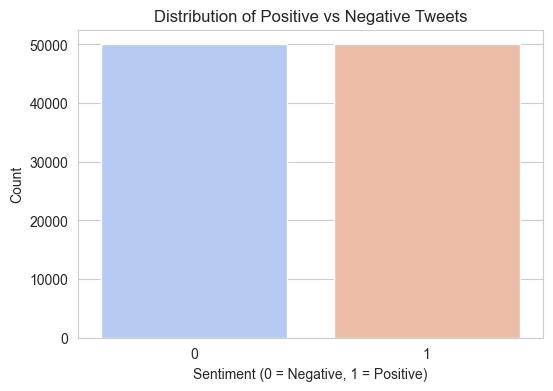

Generating Word Clouds... (This might take a moment) ⏳


C:\Users\jubur\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128515 (\N{SMILING FACE WITH OPEN MOUTH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


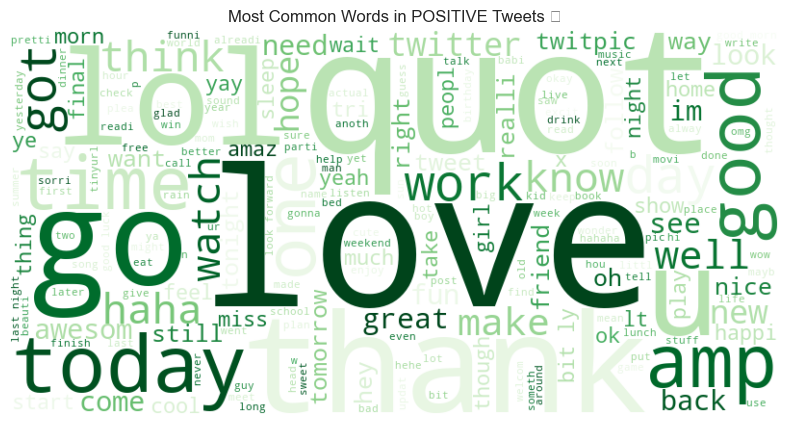

C:\Users\jubur\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128542 (\N{DISAPPOINTED FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


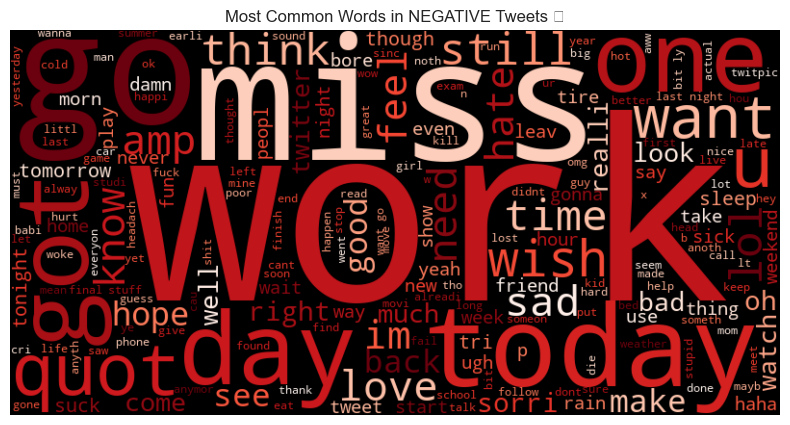

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set visual style
sns.set_style('whitegrid')

# --- VISUALIZATION 1: Class Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='coolwarm')
plt.title('Distribution of Positive vs Negative Tweets')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

# --- VISUALIZATION 2: Word Clouds (The "Brain" of the Model) ---

# Separate the text based on sentiment
# We look at 'stemmed_content' to see what the AI actually sees (roots of words)
positive_text = " ".join(df[df['target'] == 1]['stemmed_content'].astype(str))
negative_text = " ".join(df[df['target'] == 0]['stemmed_content'].astype(str))

# Create the WordClouds
print("Generating Word Clouds... (This might take a moment) ⏳")

wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Plot Positive Words
plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in POSITIVE Tweets 😃')
plt.show()

# Plot Negative Words
plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in NEGATIVE Tweets 😞')
plt.show()

Step 4: Vectorization (Text -> Numbers)
We use TF-IDF (Term Frequency-Inverse Document Frequency).

It counts how often a word appears.

It lowers the score if the word appears in every document (meaning it's not unique/special).

In [12]:
# 1. Separate Data and Label
X = df['stemmed_content'].values
y = df['target'].values

# 2. Convert Text to Numbers (TF-IDF)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

print(f"Matrix Shape: {X.shape}") 
# You will see (50000, X) where X is the number of unique words learned.

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

Matrix Shape: (100000, 78096)


Step 5: Train Model & Evaluate
We use Logistic Regression because it is incredibly fast and accurate for binary classification (Positive vs Negative).

In [13]:
# 1. Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 2. Accuracy Score
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(y_train, X_train_prediction)

X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(y_test, X_test_prediction)

print(f"Training Accuracy: {training_data_accuracy * 100:.2f}%")
print(f"Test Accuracy:     {test_data_accuracy * 100:.2f}%")

Training Accuracy: 82.43%
Test Accuracy:     76.45%


Step 6: The "Real World" Test
Let's manually type some tweets and see if the AI understands them.

In [14]:
def predict_sentiment(tweet):
    # 1. Clean the tweet using our function
    cleaned_tweet = stemming(tweet)
    
    # 2. Convert to numbers (using the SAME vectorizer)
    tweet_vector = vectorizer.transform([cleaned_tweet])
    
    # 3. Predict
    prediction = model.predict(tweet_vector)[0]
    
    if prediction == 0:
        return "😞 Negative Tweet"
    else:
        return "😃 Positive Tweet"

# --- TEST IT ---
print(predict_sentiment("I absolutely love this new phone, the camera is amazing!"))
print(predict_sentiment("The service was terrible and the food was cold."))
print(predict_sentiment("I am having a regular day, nothing special.")) # Tricky one!

😃 Positive Tweet
😞 Negative Tweet
😞 Negative Tweet
